### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Flatten, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix

# import warnings
# warnings.filterwarnings("ignore")

2022-09-29 08:24:19.634139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 08:24:19.634216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from keras.datasets import mnist
(x_train, y_train),(x_test,y_test) = mnist.load_data()

In [3]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [4]:
#convert data to rgb
x_train=tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=3)) 
x_test=tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=3))

#resize to minimum size of (32x32)
x_train=tf.image.resize_with_pad(x_train,32,32)
x_test=tf.image.resize_with_pad(x_test,32,32)

2022-09-29 08:24:31.819729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-29 08:24:31.819806: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-29 08:24:31.819848: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (addin-gurihmas-dev): /proc/driver/nvidia/version does not exist
2022-09-29 08:24:31.820316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 08:24:31.868336: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 14112000

### Building Model

In [5]:
# model = VGG16(input_shape=(32,32,3),weights='imagenet', include_top=False)
# #freeze the first 3 blocks
# for layer in model.layers[:11]:
#     layer.trainable = False
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

# top_model = model.output
# top_model = Layers.Flatten()(top_model)
# top_model = Layers.Dense(512, activation='relu')(top_model)
# top_model = Layers.Dropout(0.5)(top_model)
# top_model = Layers.Dense(64, activation='relu')(top_model)
# top_model = Layers.Dropout(0.2)(top_model)

# output_layer = Layers.Dense(10, activation='softmax')(top_model)
# model = Models.Model(inputs=model.input, outputs=output_layer)
# model.compile(optimizer=Optimizer.Adam(0.00001),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])
# model.summary()
# #Utils.plot_model(vggmodel,to_file='model.png',show_shapes=True)

In [6]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

model = tf.keras.applications.MobileNetV2(input_shape=(32 , 32, 3),
                                           include_top=False,
                                           weights='imagenet')

top_model = model.output
top_model = Layers.Flatten()(top_model)
top_model = Layers.Dense(512, activation='relu')(top_model)
top_model = Layers.Dropout(0.5)(top_model)
top_model = Layers.Dense(64, activation='relu')(top_model)
top_model = Layers.Dropout(0.2)(top_model)

output_layer = Layers.Dense(10, activation='softmax')(top_model)
model = Models.Model(inputs=model.input, outputs=output_layer)
model = Models.Model(inputs=model.input, outputs=output_layer)

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
model.compile(optimizer=Optimizer.Adam(0.00001),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5,verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
trained = model.fit(x_train,y_train,validation_split=0.3,epochs=100,callbacks=[reduce_lr,es],batch_size=32)

Epoch 1/100
1313/1313 [==============================] - 228s 168ms/step - loss: 2.5836 - accuracy: 0.1727 - val_loss: 2.3028 - val_accuracy: 0.1218 - lr: 1.0000e-05
Epoch 2/100
1313/1313 [==============================] - 220s 167ms/step - loss: 1.9427 - accuracy: 0.3249 - val_loss: 2.1868 - val_accuracy: 0.3432 - lr: 1.0000e-05
Epoch 3/100
1313/1313 [==============================] - 221s 168ms/step - loss: 1.5885 - accuracy: 0.4573 - val_loss: 1.5536 - val_accuracy: 0.6232 - lr: 1.0000e-05
Epoch 4/100
1313/1313 [==============================] - 220s 167ms/step - loss: 1.2507 - accuracy: 0.5890 - val_loss: 0.9239 - val_accuracy: 0.7621 - lr: 1.0000e-05
Epoch 5/100
1313/1313 [==============================] - 218s 166ms/step - loss: 0.9637 - accuracy: 0.6945 - val_loss: 0.6008 - val_accuracy: 0.8415 - lr: 1.0000e-05
Epoch 6/100
1313/1313 [==============================] - 219s 167ms/step - loss: 0.7718 - accuracy: 0.7641 - val_loss: 0.4469 - val_accuracy: 0.8816 - lr: 1.0000e-05
Epoc

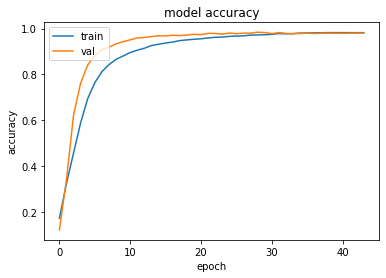

In [9]:
# summarize history for accuracy
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

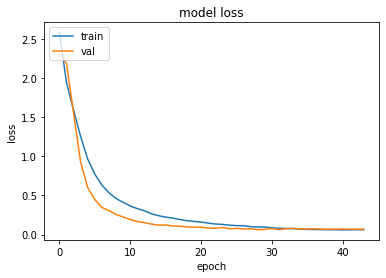

In [10]:
# summarize history for loss
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate the Model

In [5]:
model = tf.keras.models.load_model('DRmodel_VGG16.h5')

In [6]:
ModelLoss, ModelAccuracy = model.evaluate(x_test, y_test)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

313/313 [==============================] - 20s 54ms/step - loss: 0.0698 - accuracy: 0.9805
Test Loss is 0.06976897269487381
Test Accuracy is 0.9804999828338623


In [12]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
y_pred = np.argmax(model.predict(x_test),axis=1)
classes = ["Number " + str(i) for i in range(10)]
print(classification_report(y_pred, y_test, target_names = classes))

313/313 [==============================] - 8s 22ms/step
              precision    recall  f1-score   support

    Number 0       1.00      0.99      0.99       985
    Number 1       0.99      0.98      0.99      1153
    Number 2       0.93      0.99      0.96       974
    Number 3       0.99      0.98      0.98      1022
    Number 4       0.98      0.97      0.98       995
    Number 5       0.99      0.98      0.99       898
    Number 6       0.99      0.97      0.98       978
    Number 7       0.98      0.98      0.98      1029
    Number 8       0.98      0.99      0.99       965
    Number 9       0.97      0.98      0.98      1001

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



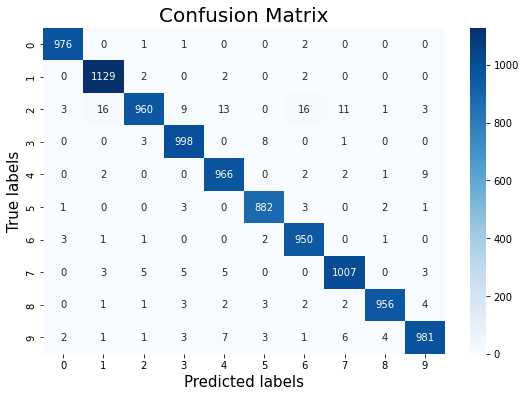

In [13]:
confusion_mtx = confusion_matrix(y_test, y_pred) 

plt.figure(figsize=(9, 6))
ax= plt.subplot()
sns.heatmap(confusion_mtx, annot=True,cmap=plt.cm.Blues, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels',size=15);
ax.set_ylabel('True labels',size=15); 
ax.set_title('Confusion Matrix',size=20); 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

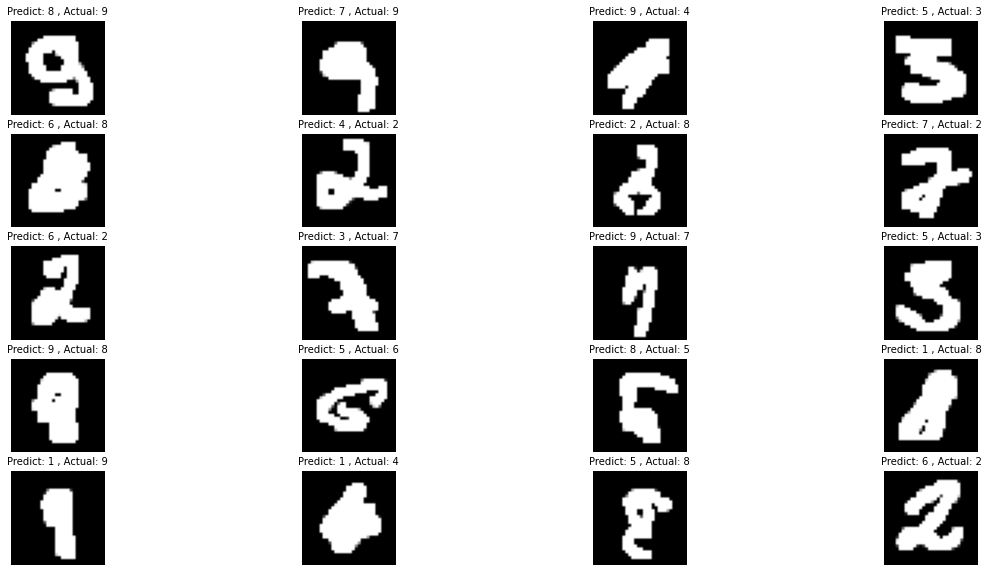

In [14]:
misclassifiedIndexes = np.where(y_pred !=y_test)[0]

fig, ax = plt.subplots(5, 4,figsize=(20,10));
ax = ax.ravel();
for i, badIndex in enumerate(misclassifiedIndexes[:20]):
    ax[i].imshow(x_test[badIndex])
    ax[i].set_title(f'Predict: {y_pred[badIndex]} , Actual: {np.array(y_test)[badIndex]}', fontsize = 10)
    ax[i].set(frame_on=False)
    ax[i].axis('off')

In [15]:
model.save("DRmodelMNIST_MobileNetV2.h5")

In [7]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
y_pred = np.argmax(model.predict(x_train),axis=1)
classes = ["Number " + str(i) for i in range(10)]
print(classification_report(y_pred, y_train, target_names = classes))

1875/1875 [==============================] - 105s 55ms/step
              precision    recall  f1-score   support

    Number 0       1.00      1.00      1.00      5934
    Number 1       1.00      0.97      0.98      6912
    Number 2       0.92      0.99      0.95      5501
    Number 3       0.99      0.99      0.99      6154
    Number 4       1.00      0.98      0.99      5934
    Number 5       0.99      0.99      0.99      5411
    Number 6       1.00      0.98      0.99      6026
    Number 7       0.99      0.98      0.99      6337
    Number 8       0.99      0.99      0.99      5849
    Number 9       0.99      0.99      0.99      5942

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000



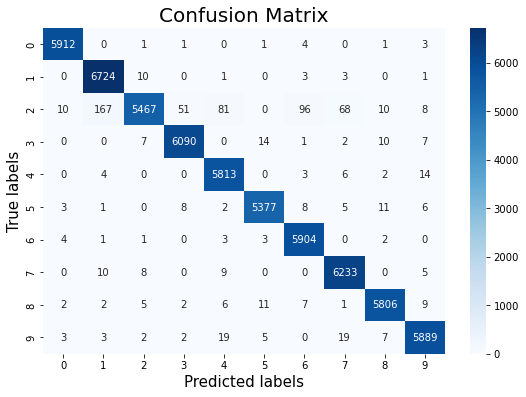

In [8]:
confusion_mtx = confusion_matrix(y_train, y_pred) 

plt.figure(figsize=(9, 6))
ax= plt.subplot()
sns.heatmap(confusion_mtx, annot=True,cmap=plt.cm.Blues, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels',size=15);
ax.set_ylabel('True labels',size=15); 
ax.set_title('Confusion Matrix',size=20); 